In [1314]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1315]:
%autoreload 2

In [1316]:
import pandas as pd
import datetime as dt
import numpy as np
import json

## Note
Please extract imply cookie from the browser and store it under implycookie.json before proceeding.

In [1317]:
from fetch_data import fetch_data

In [1318]:
org_id = "org-4TKBKn"
model_id = "model-27"

In [1319]:
df = fetch_data(org_id=org_id, model_id=model_id)

In [1320]:
df.event_columnName.unique()

array(['total_traffic'], dtype=object)

In [1321]:
if model_id == 'model-45':
    col_name = "ORDER_COUNTS"
#col_name="ORDER_LINE_COUNTS"
if model_id in ['model-27', 'model-36']:
    col_name = "total_traffic"
# col_name="total_purchase_trips"

print(f"Filter to only column: {col_name}")

df = df[df.event_columnName == col_name].reset_index()

# groupBy in Druid doesn't return data for missing days. Very important to fill in those days
timerange = pd.date_range(df.timestamp.min(), df.timestamp.max(), freq="D")
tdf = pd.DataFrame({"timestamp": timerange})

df = pd.merge(tdf, df, how='left', on='timestamp')

df

Filter to only column: total_traffic


,timestamp,index,median,event_columnName
0,2021-10-01 00:00:00+00:00,0.0,530107.0,total_traffic
1,2021-10-02 00:00:00+00:00,1.0,841084.0,total_traffic
2,2021-10-03 00:00:00+00:00,2.0,536533.0,total_traffic
3,2021-10-04 00:00:00+00:00,3.0,436523.0,total_traffic
4,2021-10-05 00:00:00+00:00,4.0,436230.0,total_traffic
...,...,...,...,...
361,2022-09-27 00:00:00+00:00,350.0,403201.0,total_traffic
362,2022-09-28 00:00:00+00:00,351.0,35111.0,total_traffic
363,2022-09-29 00:00:00+00:00,352.0,417985.0,total_traffic
364,2022-09-30 00:00:00+00:00,353.0,507924.0,total_traffic


In [1322]:
from starling.pmdarima_func import PmdArimaFunction
from starling.monitorclasses import CalculationResult, Prediction
from starling.pmdarima_func import Event
import numpy as np
from dataclasses import dataclass, asdict

In [1323]:



def arima_forecast_probabilistic_replacement(uts, windowlen=90, alpha=0.05, oob_multiple=1.0, lambda_keep=0.8,
                                             adj_tries=1, events=[]):
    uts = uts.copy()
    start = 1
    prior_results = []
    for i in range(0, start):
        prior_results.append(CalculationResult(upperThreshold=np.NaN, lowerThreshold=np.NaN, absoluteUpper=np.NaN,
                absoluteLower=np.NaN, alertCount=0, value=np.NaN, replacementValue=None, actual=None))
    for baseline_index in range(start, len(uts)):
        _start = max(0, baseline_index - windowlen)
        _end = baseline_index + 1
        assert len(prior_results) == baseline_index
        baseline_and_target = uts[_start:_end]
        target = uts.iloc[baseline_index]

        target_actual = target['median']
        # if len(baseline_and_target) < (30 + 1) or target_actual is None or np.isnan(target_actual):
        #     # don't have enough baseline; yield and empty row for this date.
        #     r = CalculationResult(upperThreshold=np.NaN, lowerThreshold=np.NaN, absoluteUpper=np.NaN,
        #             absoluteLower=np.NaN, alertCount=0, value=np.NaN, replacementValue=target_actual, actual=target_actual)
        #     prior_results.append(r)
        #     yield r
        #     continue
        baseline = baseline_and_target[:-1]

        prior_dicts = []
        for i in range(_start, _end - 1):
            timestamp = int((df.timestamp.astype(np.int64) / 10 ** 6)[i])
            pair = {timestamp: asdict(prior_results[i])}
            prior_dicts.append(pair)
        res = PmdArimaFunction.compute(
                values=baseline['median'].to_list(),
                timestamps=(baseline.timestamp.astype(np.int64) / 10 ** 6).astype(np.int64).to_list(),
                actual=target_actual,
                priors=prior_dicts,
                alpha=0.05, stddevFactor=1.0, stddevMaxBatchSize=30,
                eventPeriods=events,
                p=1, d=0, q=0, _P=2, _D=1, _Q=0, m=7,
                lambda_keep=0.5,
                oob_multiple=1.0,
        )

        r = res.to_calc_result(target_actual)
        prior_results.append(r)
        yield r

In [1324]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt


def visualize(z, limit=90, max_limit=None, min_limit=None, start=0, end=-1):
    rdf = pd.DataFrame(z)
    result = rdf.copy()
    result.index = df.timestamp[1:]
    result['real'] = df['median']

    result = result[start:end]
    result["alert"] = result.apply(
            lambda row: row["actual"] if row['alertCount'] > 0 else None, axis=1)

    result["replacement_"] = result.apply(
            lambda row: row["replacementValue"] if row['shouldReplace'] else None, axis=1)

    ribboncolor = tuple(e / 256 for e in (189, 223, 228))
    linecolor = tuple(e / 256 for e in (65, 138, 151))

    fig, ax = plt.subplots(1)
    fig.set_size_inches(20, 2.5)

    # do not plot missing data points.
    # this accurately reflects real monitor results.
    ax.plot(result.index, result['actual'], marker='o', markersize=3, lw=.5, label='Median', color=linecolor)
    ax.fill_between(result.index, result.lowerThreshold, result.upperThreshold, facecolor=ribboncolor)
    ax.plot(result.index, result['value'], marker='o', markersize=1, lw=0, color="black")
    ax.plot(result.index, result['adjustedPrediction'], marker='o', markersize=3, lw=0, color="pink")


    ax.plot(result.index, result['alert'], marker='o', markersize=2, lw=0, color="red")
    ax.plot(result.index, result['replacement_'], marker='o', markersize=2, lw=0, color="orange")

    ax.set_title(f'{model_id} pmdarim ARIMA forecast, 90-day baseline, 95% CI (lambda_keep=0.5, adj_tries=10, oob=1)')

    ax.legend(loc='upper left')
    ax.set_ylabel('est. median', fontweight='bold')
    ax.grid()
    if min_limit is not None and max_limit is not None:
        plt.ylim([min_limit, max_limit])
    plt.show()


In [1325]:
import warnings

warnings.filterwarnings("ignore")  #, category=FutureWarning)

In [1404]:
events = [
    "2021-11-21:2022-01-02",
    "2021-07-06:2021-08-08",
    "2022-07-05:2022-08-02",
]
if model_id == 'model-27' or model_id == 'model-36':
    events = [
        "2021-11-21:2022-01-02",
        "2021-07-06:2021-08-08",
        "2022-07-05:2022-08-02",
        # "2022-08-27:2022-09-05",
    ]
z1 = [x for x in arima_forecast_probabilistic_replacement(df, events=events)]

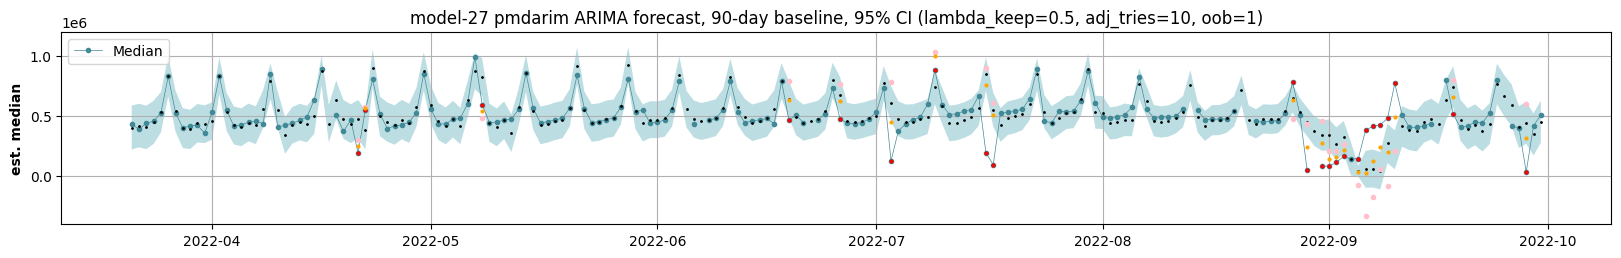

In [1405]:
if model_id == 'model-45':
    visualize(z1, start=-125, end=-1, max_limit=450 * 1000, min_limit=0 * 1000)
if model_id == 'model-36':
    visualize(z1, start=-125, end=-1, max_limit=700 * 1000, min_limit=-100 * 1000)
if model_id == 'model-27':
    visualize(z1, start=-195, end=-1, max_limit=1200 * 1000, min_limit=-400 * 1000)